# 被动源OBS数据处理手册

吴越楚

[南方科技大学海底地震仪实验室](https://obslab.sustech.edu.cn) SUSTech OBS Lab

<12131066@mail.sustech.edu.cn>

## 视频教程

**第三届佘山学堂｜地震观测新技术的应用与实践** [被动源OBS数据处理：程序和实践](https://www.koushare.com/live/details/12340?vid=36395)

**第二届OBS探测技术与应用青年学术论坛** [被动源OBS数据处理](https://www.koushare.com/live/details/39370?vid=157760)

## 1 获取数据

### 1.1 公开数据

下载公开数据，首先要获取台站元数据，若要下载地震事件数据，还要获取地震事件相关信息

#### 1.1.1 获取台站元数据


- 在[IRIS-MDA](https://ds.iris.edu/mda/)或[FDSN](https://www.fdsn.org/)上找到要下载数据的台网名称及其起止时间，通过`get_stations`获取台站元数据
- 若要获取部分台站元数据，则在`get_stations`指定台站名称
- 若要获取该台网全部台站元数据，则在`get_stations`不指定台站名称
- 若要获取多个台站或通道，使用`,`作为分隔符，例如`B01,B02`
- 台站或通道支持使用通配符`?`和`*`




In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# 台网名, 这里以 Mantle serpentinization and water cycling through the Mariana Trench and Forearc 实验为例
network_name  = 'XF'  # XF (2012-01-01 - 2013-12-31)
# 台站名
station_name  = 'B01'  

# 台网开始时间
network_starttime = UTCDateTime('2012-01-01')
# 台网结束时间
network_endtime   = UTCDateTime('2013-12-31')

# 通常'?H?' 匹配地震计通道, '??H' 匹配压力计通道 (DPG 或 APG 或 水听器)
channel_query = '?H?,??H'

# 设置通道优先级: L > B > H
# 这里优先下载低采样率数据以节省时间
priority_order = {'L': 0, 'B': 1, 'H': 2, 'E': 3}

client = Client('IRIS')

# 获取台站元数据，注意level='channel'
inventory = client.get_stations(network=network_name,
                                station=station_name,
                                channel=channel_query,
                                starttime=network_starttime,
                                endtime=network_endtime,
                                level='channel')

`inventory`包含了获取到的全部元数据

In [2]:
# print(inventory)
network = inventory[0]
station = network[0]

station_site      = station.site.name
station_starttime = station.start_date.__unicode__()
station_endtime   = station.end_date.__unicode__()
station_latitude  = station.latitude
station_longitude = station.longitude
station_elevation = station.elevation
station_channels  = station.channels

total_channels = []
for station_channel in station_channels:
    channel = station_channel.code
    total_channels.append(channel)

total_channels_str = ','.join(total_channels)

# 地震计通道
total_channels_seis = [x for x in total_channels if x[1] == 'H']
# 压力计通道
total_channels_pres = [x for x in total_channels if x[-1] == 'H']

total_channels_seis.sort(key=lambda x:priority_order.get(x[0]))
total_channels_pres.sort(key=lambda x:priority_order.get(x[0]))
if total_channels_seis and total_channels_pres:
    channels_seis_str = ','.join(total_channels_seis[0:3])
    channel_pres = total_channels_pres[0]
    channels_str = ','.join([channels_seis_str,channel_pres])
elif not total_channels_pres:
    channels_str = ','.join(total_channels_seis[0:3])
elif not total_channels_seis:
    channels_str = total_channels_pres[0]
else:
    channels_str = ''

channels = channels_str.split(',')

print('台网名', network_name)
print('台站名', station_name)
print('台站站点', station_site)
print('台站开始时间', station_starttime)
print('台站结束时间', station_endtime)
print('台站纬度 (°)', station_latitude)
print('台站经度 (°)', station_longitude)
print('台站高程 (m)', station_elevation)
print('通道', channels)

台网名 XF
台站名 B01
台站站点 SIO OBS ID B01
台站开始时间 2012-01-29T00:00:00.000000Z
台站结束时间 2013-02-04T23:59:59.000000Z
台站纬度 (°) 16.040501
台站经度 (°) 149.281494
台站高程 (m) -5321.0
通道 ['HH1', 'HH2', 'HHZ', 'EDH']


#### 1.1.2 获取地震信息

通过`get_events`获取地震事件信息

8 Event(s) in Catalog:
2013-01-05T08:58:19.180000Z | +55.235, -134.801 | 7.5  MW
2012-10-28T03:04:07.790000Z | +52.678, -132.172 | 7.8  MW
2012-09-05T14:42:07.730000Z | +10.024,  -85.388 | 7.6  MW
2012-08-31T12:47:35.540000Z | +10.811, +126.826 | 7.6  MW
2012-08-14T02:59:38.860000Z | +49.750, +145.306 | 7.7  MW
2012-04-11T10:43:10.530000Z |  +0.767,  +92.428 | 8.2  MW
2012-04-11T08:38:37.800000Z |  +2.238,  +93.014 | 8.6  MW
2012-03-20T18:02:47.620000Z | +16.473,  -98.369 | 7.5  MW


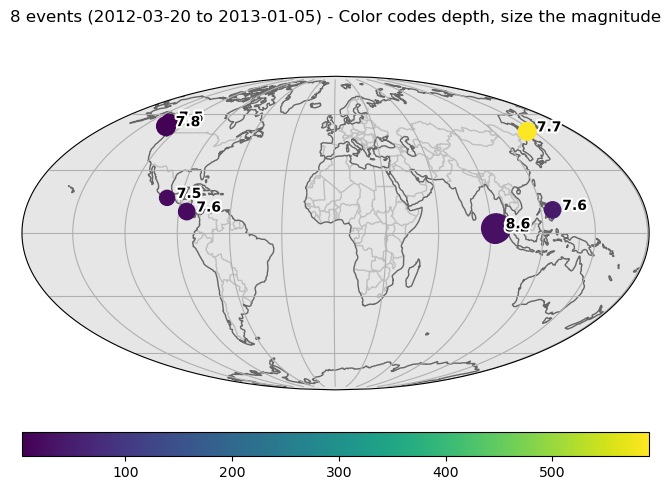

In [3]:
# 最小震级
minmag = 7.5

# 获取地震目录
catalog = client.get_events(starttime=station_starttime, endtime=station_endtime, minmag=minmag)

# 打印全部地震目录
print(catalog.__str__(print_all=True))

# 禁止返回axis，防止图重复出现
_ = catalog.plot()

`catalog`包含了获取的全部地震信息，这里打印第二个地震事件信息

In [4]:
# 选择第二个事件
event = catalog[1]

eventid         = event.resource_id.id.split('eventid=')[-1]
origin          = event.origins[0]
otime_str       = origin.time.__unicode__()
event_latitude  = origin.latitude
event_longitude = origin.longitude     
event_depth     = origin.depth*0.001  # 事件深度的单位是 km      
magnitude_type  = event.magnitudes[0].magnitude_type
magnitude       = event.magnitudes[0].mag
description     = event.event_descriptions[0].text

print('事件ID', eventid)
print('事件发生时刻', otime_str)
print('事件纬度 (°)', event_latitude)
print('事件经度 (°)', event_longitude)
print('事件深度 (km)', event_depth)
print('震级类型', magnitude_type)
print('震级', magnitude)
print('描述', description)

事件ID 3533701
事件发生时刻 2012-10-28T03:04:07.790000Z
事件纬度 (°) 52.6777
事件经度 (°) -132.1724
事件深度 (km) 7.4
震级类型 MW
震级 7.8
描述 QUEEN CHARLOTTE ISLANDS REGION


#### 1.1.3 计算震中距及方位角、反方位角

这几个参数在SAC中都有其特定的头文件名，这里的`distance_in_degree`即SAC中的`gcarc`,这里的`distance_in_km`即SAC中的`dist`

- gcarc：全称great circle arc，即震中到台站的大圆弧的长度，单位为 °
- dist：震中到台站的距离，单位为 km
- az：方位角，震中到台站的连线与地理北向的夹角，单位为 °
- baz：反方位角，台站到震中的连线与地理北向的夹角，单位为 °

In [5]:
from obspy.geodetics import gps2dist_azimuth
from obspy.geodetics import kilometer2degrees

distance_in_m, baz, az = gps2dist_azimuth(station_latitude, station_longitude, event_latitude, event_longitude)
distance_in_km = distance_in_m*0.001
distance_in_degree = kilometer2degrees(distance_in_km)

print('震中距 (km)', distance_in_km)
print('震中距 (°)', distance_in_degree)
print('反方位角 (°)', baz)
print('方位角 (°)', az)

震中距 (km) 7835.481642983728
震中距 (°) 70.4661793431486
反方位角 (°) 39.19244494078104
方位角 (°) 271.0709001778372


#### 1.1.4 计算震相理论到时

基于一维地球模型计算指定震相的理论到时，同时根据瑞利波速度计算瑞利面波的大致时间窗

In [6]:
from obspy.taup import TauPyModel

# 瑞利波速度的上下限 (km/s)
Rayleigh_velocity = [3, 4.5]

# 指定模型为iasp91
model = TauPyModel(model='iasp91')

# 指定震相为P和S
P_arrivals = model.get_travel_times(source_depth_in_km=event_depth, distance_in_degree=distance_in_degree, phase_list='P')
S_arrivals = model.get_travel_times(source_depth_in_km=event_depth, distance_in_degree=distance_in_degree, phase_list='S')
                
# 瑞利波时间窗
Rayleigh_begin = distance_in_km / Rayleigh_velocity[1]
Rayleigh_end   = distance_in_km / Rayleigh_velocity[0]

#### 1.1.5 下载地震数据

通过`get_waveforms`下载地震波形数据，下载的数据会成为一个 Stream 对象  

Stream 对象类似一个包含多个 Trace 对象（无间隙连续时间序列和相关的对象元数据）的列表

In [7]:
import os
from obspy import Stream

location = '--'  # 对于OBS, location通常是'--'

# 地震事件长度 (单位: s)
event_length = 7200

# 事件文件的开始时间(相对于发震时刻的秒数)
btime = -600

otime = UTCDateTime(otime_str)

starttime = otime + btime
endtime   = otime + event_length + btime

starttime_str = starttime.datetime.strftime('%Y-%m-%dT%H:%M:%S')
endtime_str   = endtime.datetime.strftime('%Y-%m-%dT%H:%M:%S')

sts = Stream()
for channel in channels:
    
    print(f'Downloading station: {station_name} channel: {channel} from: {starttime_str} to: {endtime_str}')
    st = client.get_waveforms(network=network_name, station=station_name, location=location, channel=channel, 
                              starttime=starttime, endtime=endtime, attach_response=True)
    
    sts += st

#### 1.1.6 绘制下载的波形

4 Trace(s) in Stream:
XF.B01..HH1 | 2012-10-28T02:54:07.798781Z - 2012-10-28T04:54:07.788781Z | 100.0 Hz, 720000 samples
XF.B01..HH2 | 2012-10-28T02:54:07.798781Z - 2012-10-28T04:54:07.788781Z | 100.0 Hz, 720000 samples
XF.B01..HHZ | 2012-10-28T02:54:07.798781Z - 2012-10-28T04:54:07.788781Z | 100.0 Hz, 720000 samples
XF.B01..EDH | 2012-10-28T02:54:07.798781Z - 2012-10-28T04:54:07.788781Z | 100.0 Hz, 720000 samples


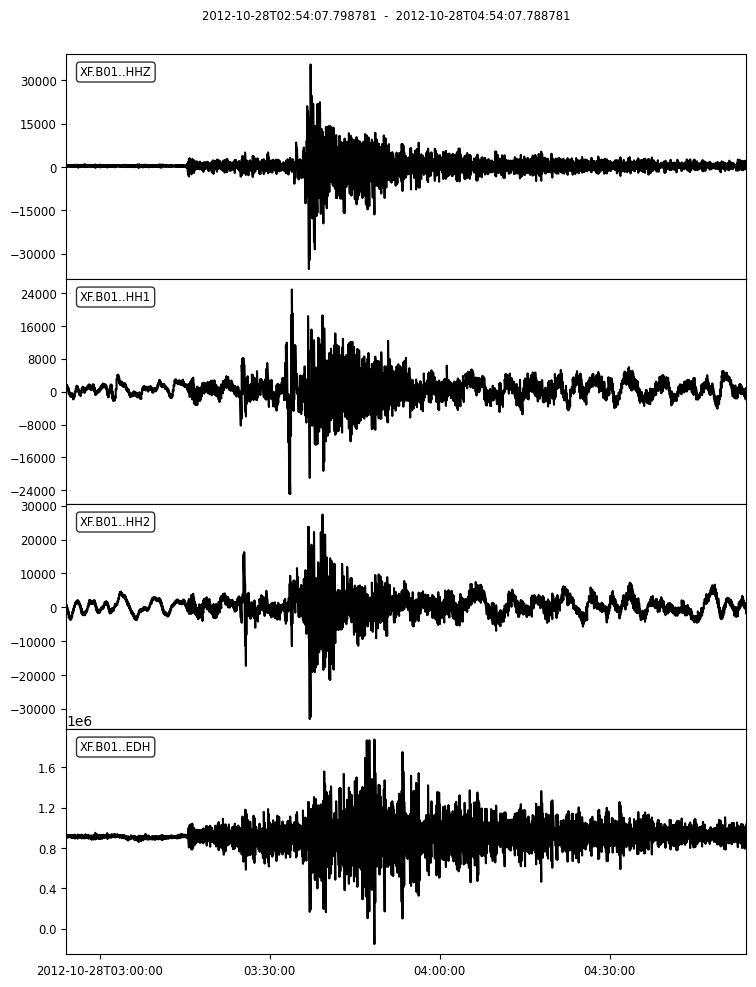

In [8]:
# 打印下载的数据信息
print(sts)

# 绘图，各子图范围不相同
_ = sts.plot(equal_scale=False)

#### 1.1.7 自动下载地震数据程序包`DownloadSeisData`

[DownloadSeisData](https://github.com/SeisPiano/DownloadSeisData)是一款自动下载地震数据和数据预处理的软件包，目前提供了Python和Shell版本。

`DownloadSeisData`可以自动下载台站元数据、每日波形数据和仪器响应文件。此外，它还可以根据台站元数据自动下载地震目录和地震事件波形数据。所有波形数据均以SAC格式保存。由于下载了相应的仪器响应文件，可以将波形的单位转换为位移、速度、加速度（地震计）或压力（压力计）。同时， `DownloadSeisData`还将台站信息和事件信息等相关参数保存在SAC头段变量中以供后续使用。

## 1.2 本地数据

###  1.2.1 读取本地数据
通过`read`模块读取本地数据，`obspy`的`read`函数几乎支持所有的地震数据格式（如 SAC、MiniSEED 等），读取的数据会成为一个 Stream 对象，与下载的公开数据一致

1 Trace(s) in Stream:
3S.P03.--.HHZ | 2023-07-16T00:00:00.000000Z - 2023-07-16T23:59:59.990000Z | 100.0 Hz, 8640000 samples


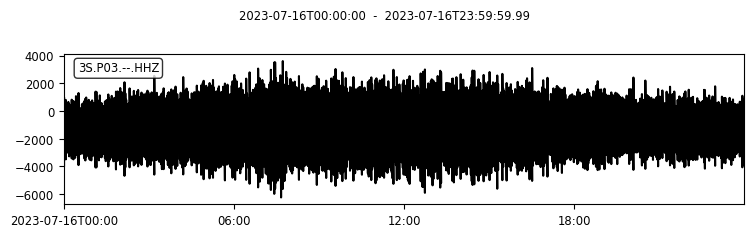

In [9]:
from obspy import read

# 本地数据路径
local_data_dir = 'DATA/local_data'
network = '3S'
station = 'P03'
date = '230716'

filename = '3S.P03.HHZ_20230716_000000.mseed'

st = read(os.path.join(local_data_dir,network,station,date,filename))

print(st)

_ = st.plot()

### 1.2.2 截取地震事件数据

通过`trim`截取指定时间范围的数据

事件发生时刻 2023-07-16T06:48:21.155000Z


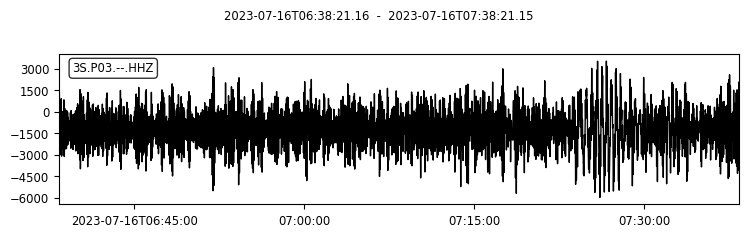

In [10]:
# 首先获取地震目录
catalog = client.get_events(starttime=UTCDateTime('2023-07-16'), endtime=UTCDateTime('2023-07-17'), minmag=7)

# 选择第1条地震信息
event = catalog[0]
print('事件发生时刻',event.origins[0].time)

# 截取的事件长度为 3600 s
event_length = 3600

# 截取的起始时间为发震时刻前600 s
starttime = event.origins[0].time - 600
endtime = starttime + event_length

st_event = st.trim(starttime=starttime,endtime=endtime)

_ = st_event.plot()

## 2 数据预处理

###  2.1 去除仪器响应

地震仪观测到的地面运动记录可以表示为：
$$
u(t) = s(t) * g(t) * i(t)
$$
其中$s(t)$代表震源项，$g(t)$代表路径效应，$i(t)$代表仪器响应，$*$代表卷积  

为了得到台站绝对振幅值，反映真实的地面位移（或速度、加速度），需要去除仪器响应

#### 2.1.1 公开数据

对于公开数据，只需在下载波形数据时指定`attach_response=True`，后续即可非常方便的去除仪器响应



原始波形


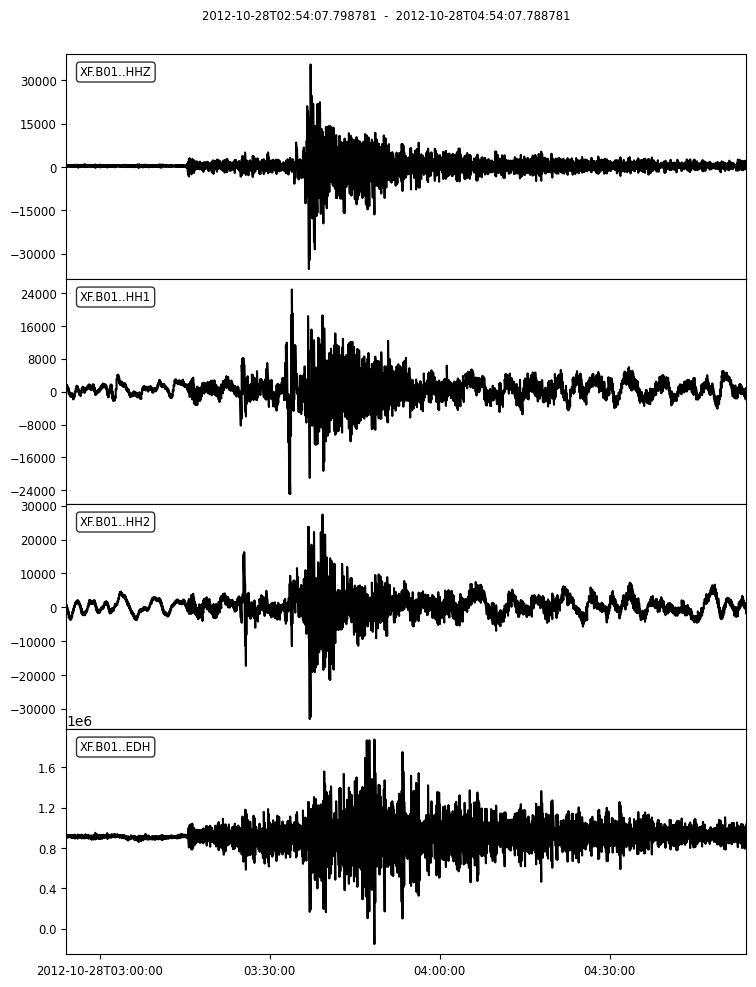

去除仪器响应之后的波形


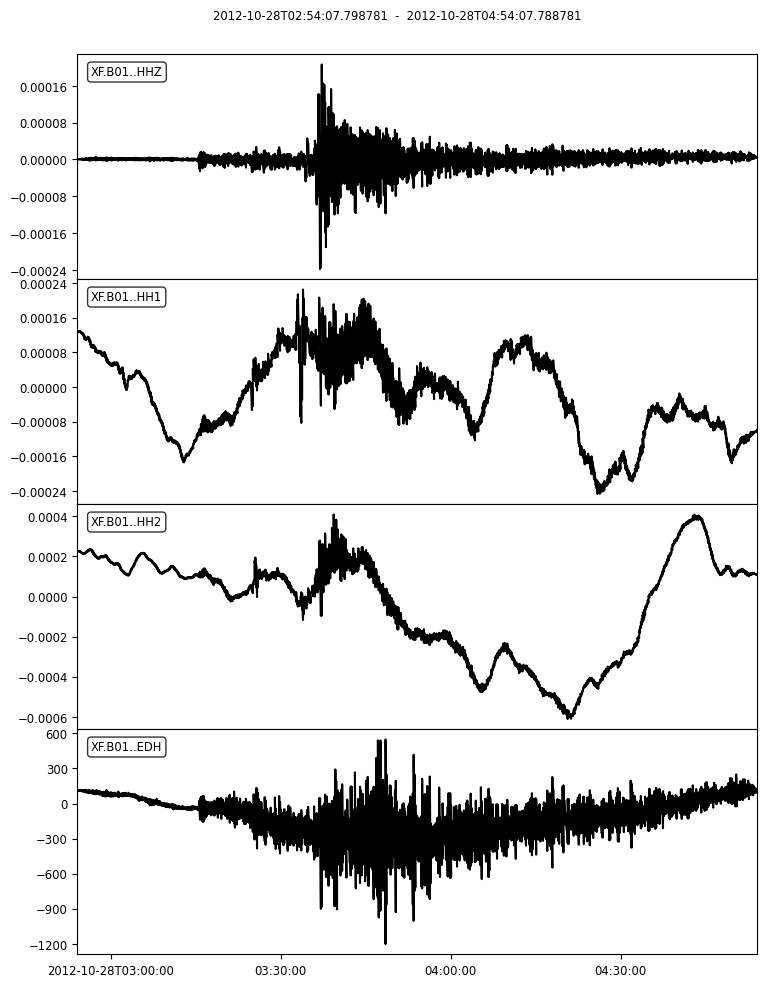

In [11]:
# 原始波形
print('原始波形')
_ = sts.plot(equal_scale=False)

# 地震计可以去除仪器响应至 位移: DISP (m)，速度: VEL (m/s)，加速度: ACC (m/s^2)
# 压力计可去除仪器响应至 默认: DEF (Pa)

# 去除仪器响应，前3个通道为地震计，第4个通道为压力计
sts[0:3].remove_response(output='VEL') # 此时地震波形的单位为 速度 (m/s)
sts[-1].remove_response(output='DEF')  # 此时压力波形的单位为 压强 (Pa)

# 注意去除仪器响应前后纵轴范围的变化
print('去除仪器响应之后的波形')
_ = sts.plot(equal_scale=False)

#### 2.1.2 本地数据
`SUSTech OBS Lab` 自主研发的磐鲲OBS仪器响应文件如下：  

- 仪器响应文件仅作展示，无需运行

需要注意：
- 磐鲲原始仪器响应文件有2个“零”零点，此时去除仪器响应至速度 (m/s)
- 若增加1个“零”零点，即有3个“零”零点，此时去除仪器响应至位移 (m)
- 若减少1个“零”零点，即有1个“零”零点，此时去除仪器响应至加速度 (m/s^2)

In [ ]:
"""
Instrument response for Pankun OBS

Seismometer response can be get from:
https://ds.iris.edu/NRL/sensors/nanometrics/RESP.XX.NS124..BHZ.TrilliumCompact120.120.754

Yuechu Wu
12131066@mail.sustech.edu.cn
2024-01-30
"""

# Instrument response for Pankun OBS
# Yuechu Wu
# 2023-12-12

# A0 normalization factor:                  4.344928E+17
# Sensor gain:                              7.543000E+02
# Digitiser gain (calibrated by Dan Liu):   3.494000E+05                 



paz_seis = {'gain': 4.344928E+17, 
     
            'poles': [-3.691000E-02 + 3.702000E-02j,  
                      -3.691000E-02 - 3.702000E-02j,  
                      -3.430000E+02 + 0.000000E+00j,  
                      -3.700000E+02 + 4.670000E+02j,  
                      -3.700000E+02 - 4.670000E+02j,  
                      -8.360000E+02 + 1.522000E+03j,  
                      -8.360000E+02 - 1.522000E+03j,  
                      -4.900000E+03 + 4.700000E+03j,  
                      -4.900000E+03 - 4.700000E+03j,  
                      -6.900000E+03 + 0.000000E+00j,  
                      -1.500000E+04 + 0.000000E+00j,  
                       ],
     
             'zeros': [0.000000E+00 + 0.000000E+00j,  
                       0.000000E+00 + 0.000000E+00j,  
                      -3.920000E+02 + 0.000000E+00j,  
                      -1.960000E+03 + 0.000000E+00j,  
                      -1.490000E+03 + 1.740000E+03j,  
                      -1.490000E+03 - 1.740000E+03j,  
                       ], 
     
            'sensitivity': 2.6355242E+08,
             }

# Instrument response for Pankun OBS



# Instrument response with transfer function = 1
# 目前没有准确的压力仪器响应文件，该文件旨在乘以一个修正系数gain
paz_pres = {'gain': -1, # 不同批次可能不同，对于2023年磐鲲南海测试，gain = -1
           'poles': [1 + 0j],           
           'sensitivity': 1,
           'zeros': [1 + 0j],
           }


原始波形


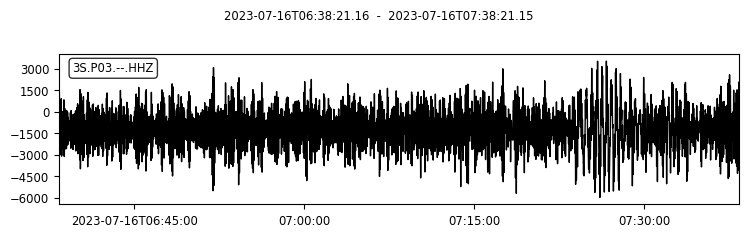

去除仪器响应之后的波形


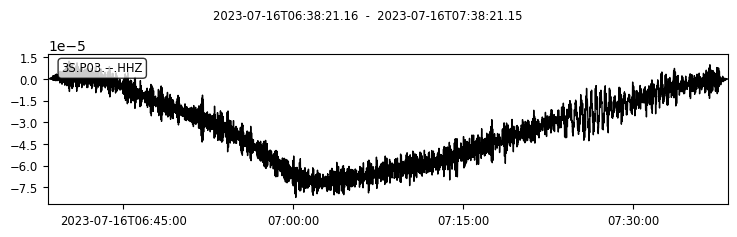

In [12]:
from paz_obslab import paz_seis

# 原始波形
print('原始波形')
_ = st_event.plot()

# 去除仪器响应
st_event.simulate(paz_remove=paz_seis) # 此时地震波形的单位为 速度 (m/s)

# 注意去除仪器响应前后纵轴范围的变化
print('去除仪器响应之后的波形')
_ = st_event.plot() 

### 2.2 去均值、去线性趋势、波形尖灭

- 去均值：去除波形数据的平均值。
- 去线性趋势：将数据拟合成一条直线，然后从数据中减去该直线所表征的线性趋势。
- 波形尖灭：将波形数据的首尾两端由其原始值不断光滑地减小到0。

去均值、去线性趋势、波形尖灭后的波形


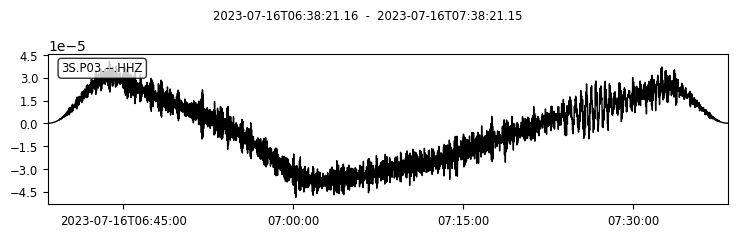

In [13]:
# 去均值
st_event.detrend('demean')
# 去线性趋势
st_event.detrend('linear')
# 波形尖灭（即波形两端逐渐变成0）
st_event.taper(max_percentage=0.1)

print('去均值、去线性趋势、波形尖灭后的波形')
_ = st_event.plot()

### 2.3 滤波

- 带通滤波：只保留特定频段的波形，同时屏蔽其他频段的波形。

滤波后的波形


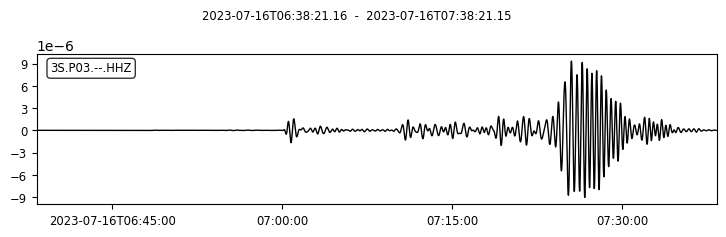

In [14]:
# 滤波至0.02-0.04 Hz (25-50 s)
st_event.filter('bandpass',freqmin=0.02,freqmax=0.04)

print('滤波后的波形')
_ = st_event.plot()

### 2.4 重采样

In [15]:
print('原始采样率', st_event[0].stats.sampling_rate)

# 使用resample进行重采样
st_event.resample(5)

print('新的采样率', st_event[0].stats.sampling_rate)

原始采样率 100.0
新的采样率 5.0


### 2.5 将信息写入SAC头文件

In [16]:
from obspy.io.sac import SACTrace

# 选择前面下载的XF-B01台站的Z分量波形
channel = 'HHZ'
st = sts[2]  # 选择Z分量

# 存放地震事件数据的文件夹
output_dir = 'DATA/sacdata_event'

event_name = otime.datetime.strftime('%Y%m%d_%H%M%S')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if not os.path.exists(f'{output_dir}/{event_name}'):
    os.makedirs(f'{output_dir}/{event_name}')

filename = os.path.join(output_dir,event_name,f'{event_name}_{network_name}_{station_name}_{channel}.SAC')

# 首先将Stream对象写为SAC文件
st.write(filename, format='SAC')

# 只读取头文件
sac = SACTrace.read(filename, headonly=True)

##### 写SAC头文件 #####
sac.knetwk = network_name
sac.kstnm  = station_name
sac.khole  = location
sac.kcmpnm = channel               

sac.stla = station_latitude
sac.stlo = station_longitude
sac.stel = station_elevation

sac.evla = event_latitude
sac.evlo = event_longitude
sac.evdp = event_depth
sac.mag  = magnitude

sac.gcarc = distance_in_degree
sac.dist  = distance_in_km            
sac.az    = az
sac.baz   = baz

sac.o      = otime
sac.iztype = 'io'    
sac.ko     = 'O'

# P和S预测到时
if P_arrivals:    
    sac.a   = otime + P_arrivals[0].time
    sac.t0  = otime + S_arrivals[0].time
    sac.ka  = 'P'
    sac.kt0 = 'S'
      
# 瑞利波窗口
sac.t1  = otime + Rayleigh_begin
sac.t2  = otime + Rayleigh_end
sac.kt1 = 'RayStart'
sac.kt2 = 'RayEnd'
      
##### 写入发震时刻 #####
# 日期，时，分，秒的整数
sac.kevnm = otime_str[0:4] + otime_str[5:7] + otime_str[8:10] + \
            otime_str[10:13] + otime_str[14:16] + otime_str[17:19]
# 秒的小数
sac.kuser0 = otime_str[19:27]

# 震级类型
sac.kuser1 = magnitude_type

# 只写头文件，文件必须存在
sac.write(filename, headonly=True)

In [17]:
# 读取SAC头文件，此时头段变量已保存
sac = SACTrace.read(filename, headonly=True)

print(sac)

Reference Time = 10/28/2012 (302) 03:04:07.790000
	iztype IO: origin time
a          = 675.0648803710938
az         = 271.0708923339844
b          = -599.9912109375
baz        = 39.19244384765625
delta      = 0.009999999776482582
depmax     = 0.0002062013663817197
depmen     = -1.94169743394923e-07
depmin     = -0.00023792244610376656
dist       = 7835.4814453125
e          = 6599.998628130183
evdp       = 7.400000095367432
evla       = 52.67770004272461
evlo       = -132.17239379882812
gcarc      = 70.46617889404297
iftype     = itime
iztype     = io
ka         = P
kcmpnm     = HHZ
kevnm      = 20121028T030407
khole      = --
knetwk     = XF
ko         = O
kstnm      = B01
kt0        = S
kt1        = RayStart
kt2        = RayEnd
kuser0     = .790000Z
kuser1     = MW
lcalda     = False
leven      = True
lovrok     = True
lpspol     = True
mag        = 7.800000190734863
npts       = 720000
nvhdr      = 6
nzhour     = 3
nzjday     = 302
nzmin      = 4
nzmsec     = 790
nzsec      = 7
nzye

## 3 绘制概率功率谱密度（PPSD）

PPSD（probability power spectral density） 是一种常用的分析地震噪声的方法，用于研究地震仪记录的背景噪声的频率分布和时间变化。它通过统计噪声的功率谱密度（power spectral density, PSD）在不同时间段的概率分布来揭示地震仪记录数据中噪声水平的动态特性。

### 3.1 公开数据

仪器响应


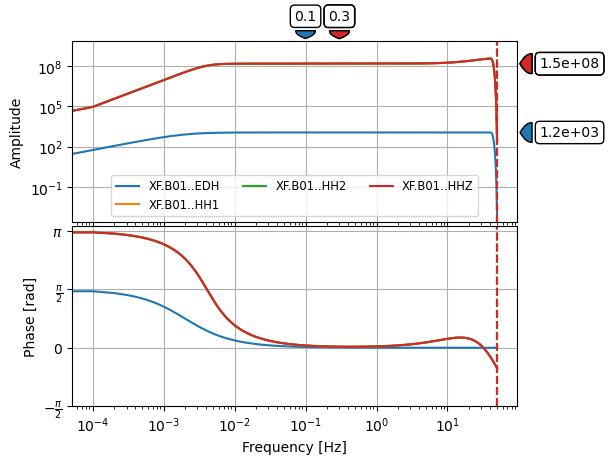

功率谱密度


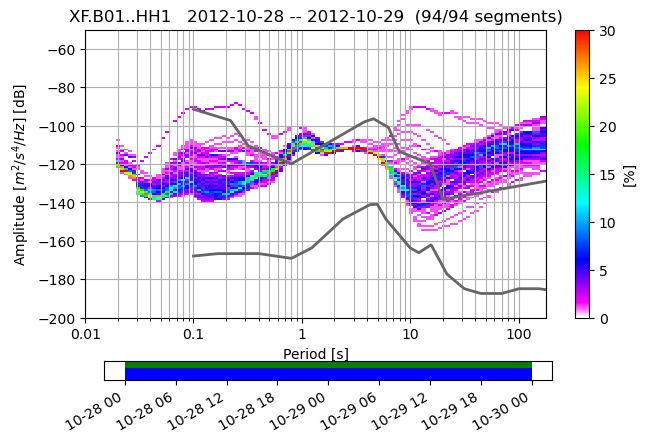

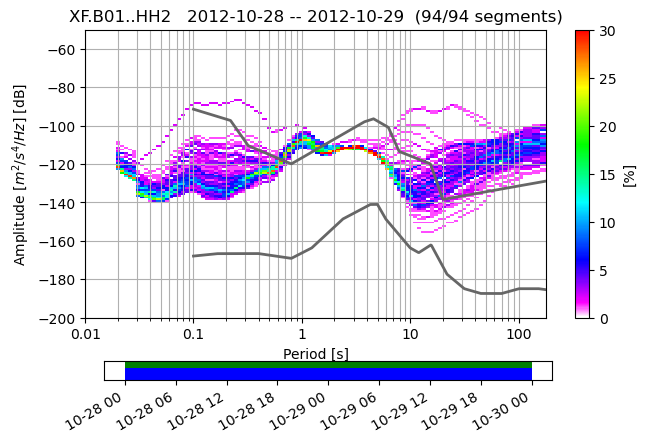

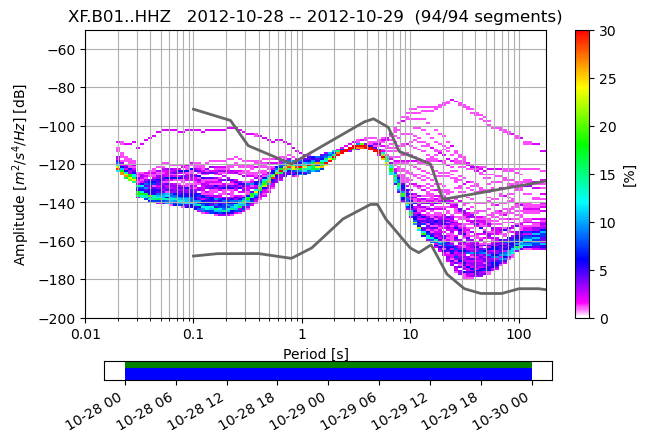

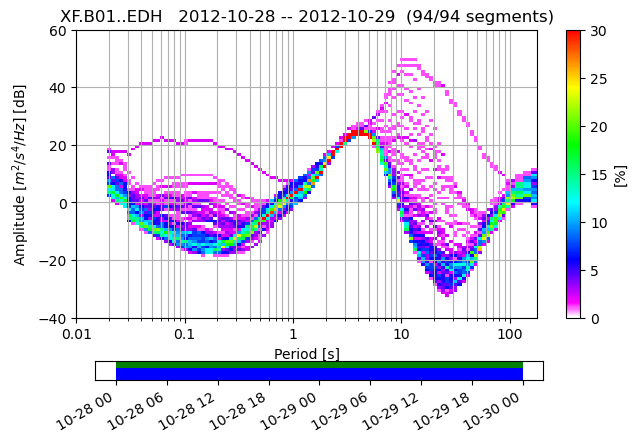

In [18]:
from obspy.signal import PPSD
from obspy.imaging.cm import pqlx

network = 'XF'
station = 'B01'
location = '--'
channels = ['HH1', 'HH2', 'HHZ', 'EDH']

startdate = '2012-10-28' # 下载波形数据的开始时间
enddate   = '2012-10-30' # 下载波形数据的结束时间

# 获取仪器响应，注意level='response'
inventory = client.get_stations(network=network, station=station, level='response')

# 绘制仪器响应
print('仪器响应')
_ = inventory.plot_response(min_freq=1E-4)

# inventory.write('instrument_response.xml', format='STATIONXML')

print('功率谱密度')

for channel in channels:
    starttime = UTCDateTime(startdate)
    endtime = starttime + 86400
    inventory = client.get_stations(network=network, station=station, channel=channel, level='response')
    
    while starttime < UTCDateTime(enddate):
        
        st = client.get_waveforms(network=network, station=station, location=location, channel=channel,
                                  starttime=starttime, endtime=endtime)
        
        if starttime == UTCDateTime(startdate):
             
            tr = st[0]
            if channel == 'EDH':
                ppsd = PPSD(tr.stats, metadata=inventory, db_bins=(-40,60,1.0))
            else:
                ppsd = PPSD(tr.stats, metadata=inventory)
            ppsd.add(st)
        else:
            ppsd.add(st)
            
        starttime += 86400
        endtime += 86400
    
    _ = ppsd.plot(cmap=pqlx)

### 3.2 本地数据

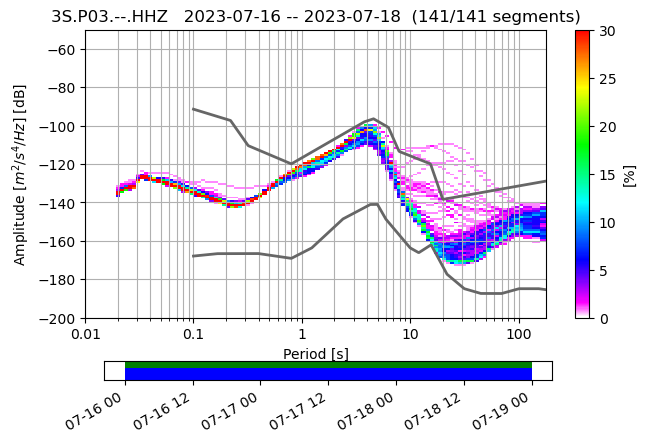

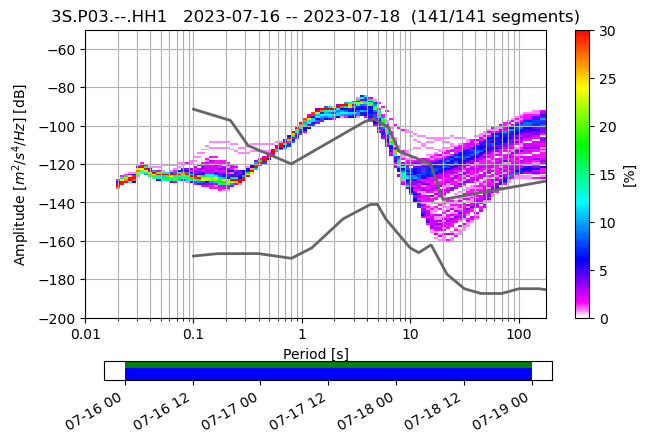

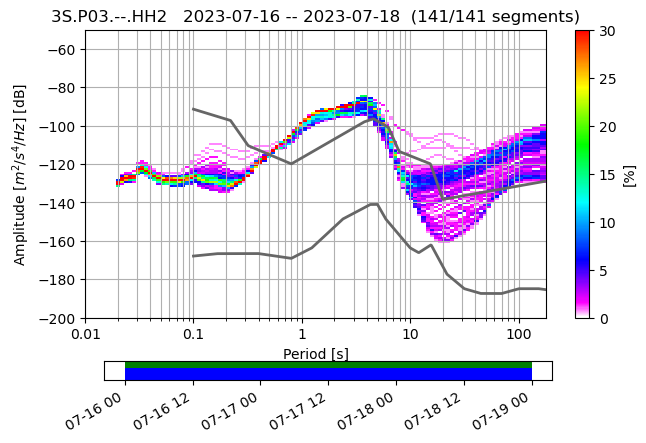

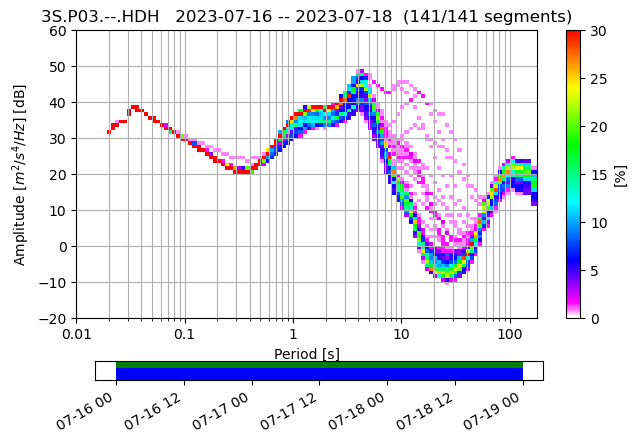

In [19]:
from datetime import datetime
from paz_obslab import paz_pres

local_data_dir = 'DATA/local_data'
network = '3S'
station = 'P03'
location = '--'
channels = ['HHZ','HH1','HH2','HDH']

station_dir = os.path.join(local_data_dir,network,station)

date_folders = [f for f in os.listdir(station_dir) if os.path.isdir(os.path.join(station_dir, f))]
date_folders = sorted(date_folders, key=lambda x: datetime.strptime(x, '%y%m%d'))

for channel in channels:
    i = 0
    for date_folder in date_folders:
        data_dir = os.path.join(station_dir, date_folder)
        for filename in os.listdir(data_dir):           
            if channel in filename:
                st = read(os.path.join(data_dir, filename))
                tr = st[0]
                if i == 0:   
                    # 不同通道使用不同的仪器响应文件及纵坐标范围
                    if channel == 'HDH':
                        ppsd = PPSD(tr.stats, paz_pres, db_bins=(-20,60,1.0))
                    else:
                        ppsd = PPSD(tr.stats, paz_seis)
                
                ppsd.add(st)
                
                i += 1
    
    _ = ppsd.plot(cmap=pqlx)

## 4 确定水平方位角

陆地地震仪在布设时，需要将其N分量指向地理北向。然而海底地震仪（ocean bottom seismograph, OBS）一般采用自由沉入海底的布设方式，其N分量的指向是随机的，因此需要通过数据分析的方法确定OBS的水平方位角。

这里我们使用 Stachnik et al. (2012)的方法来确定OBS的水平方位角，该方法是基于瑞利波（Rayleigh wave）的极化实现的。瑞利波在垂向（Z）和径向（R）上存在90°的相位差，因此我们可以通过旋转水平分量与垂直分量的希尔伯特变换（Z Hilbert）求相关性，从而确定N分量到径向的旋转角（$θ$），再由径向（$baz$）和旋转的角度（$θ$）确定N分量的方位（$X$），即OBS的水平方位角：
$$
X = baz - θ
$$

最后，通过台站布设期间记录的多个地震事件获得水平方位角的统计结果，最终确定OBS的水平方位角。

### 4.1 Matlab程序包`orient`

[orient](https://github.com/SeisPiano/orient)程序包可以自动计算地震面波的信噪比并确定OBS的水平方位角，同时也可以手动挑选地震面波再确定OBS的水平方位角。

### 4.2 Python程序包`OrientPy`

`OrientPy`是一个工具箱，通过自动（和手动）处理地震数据来帮助确定地震计的方向。这些方法对OBS台站特别有用，但也适用于宽频带陆地台站或短周期OBS（取决于所选的方法）。该代码使用`StDb`包查询和构建台站数据库，可以通过命令行脚本使用。目前，该工具箱包括以下方法：

- DL（Doran and Laske, 2017）：基于不同频率范围内的瑞利波极化以及两种基阶模态瑞利波轨道。

- BNG（Braunmiller, Nabelek and Ghods, 2020）：基于区域地震和远震的P波极化。

每种方法都可以独立用于确定台站的水平方位角，即地震分量1（或N）的方位角。



## 5 去除倾斜噪声和屈服噪声

### 5.1 Matlab程序包`ATaCR`

自动去除倾斜和屈服噪声（Automated Tilt and Compliance Removal）（[ATaCR](https://github.com/helenjanisz/ATaCR)，读作attacker）程序包，用于描述和去除海底地震仪（ocean bottom seismograph, OBS）数据中的倾斜噪声（tilt noise）和屈服噪声（compliance noise）。根据Crawford and Webb (2000)以及Bell et al. (2015)的方法进行倾斜和屈服噪声校正。更多详细信息，请参阅[ATaCR手册](https://github.com/helenjanisz/ATaCR/blob/master/ATaCR_Manual.pdf)。


### 5.2 Pthon程序包`OBStools`

ATaCR的Python版，该代码使用`StDb`包查询和构建台站数据库，可以通过命令行脚本使用。

## 6 去除谐波噪声

谐波噪声（harmonic noise）是一种普遍存在于 OBS 数据中的噪声，这种噪声没有特定的来源，但其特点与地震信号有明显不同。地震信号类似于冲击信号，是宽带瞬态信号。而谐波噪声相比地震信号更为窄带且长时间存在。

[NoiseCut](https://github.com/ZahraZali/NoiseCut)程序包通过谐波冲击分离（harmonic–percussive separation, HPS ）算法去除 OBS 数据中的谐波噪声，以分离 OBS 数据中的“谐波”（长期窄带信号）和“冲击”（宽带瞬态）分量，旨在降低噪声水平并得到更清晰的宽带地震波形。


## 7 使用pyGMT绘制台站位置图

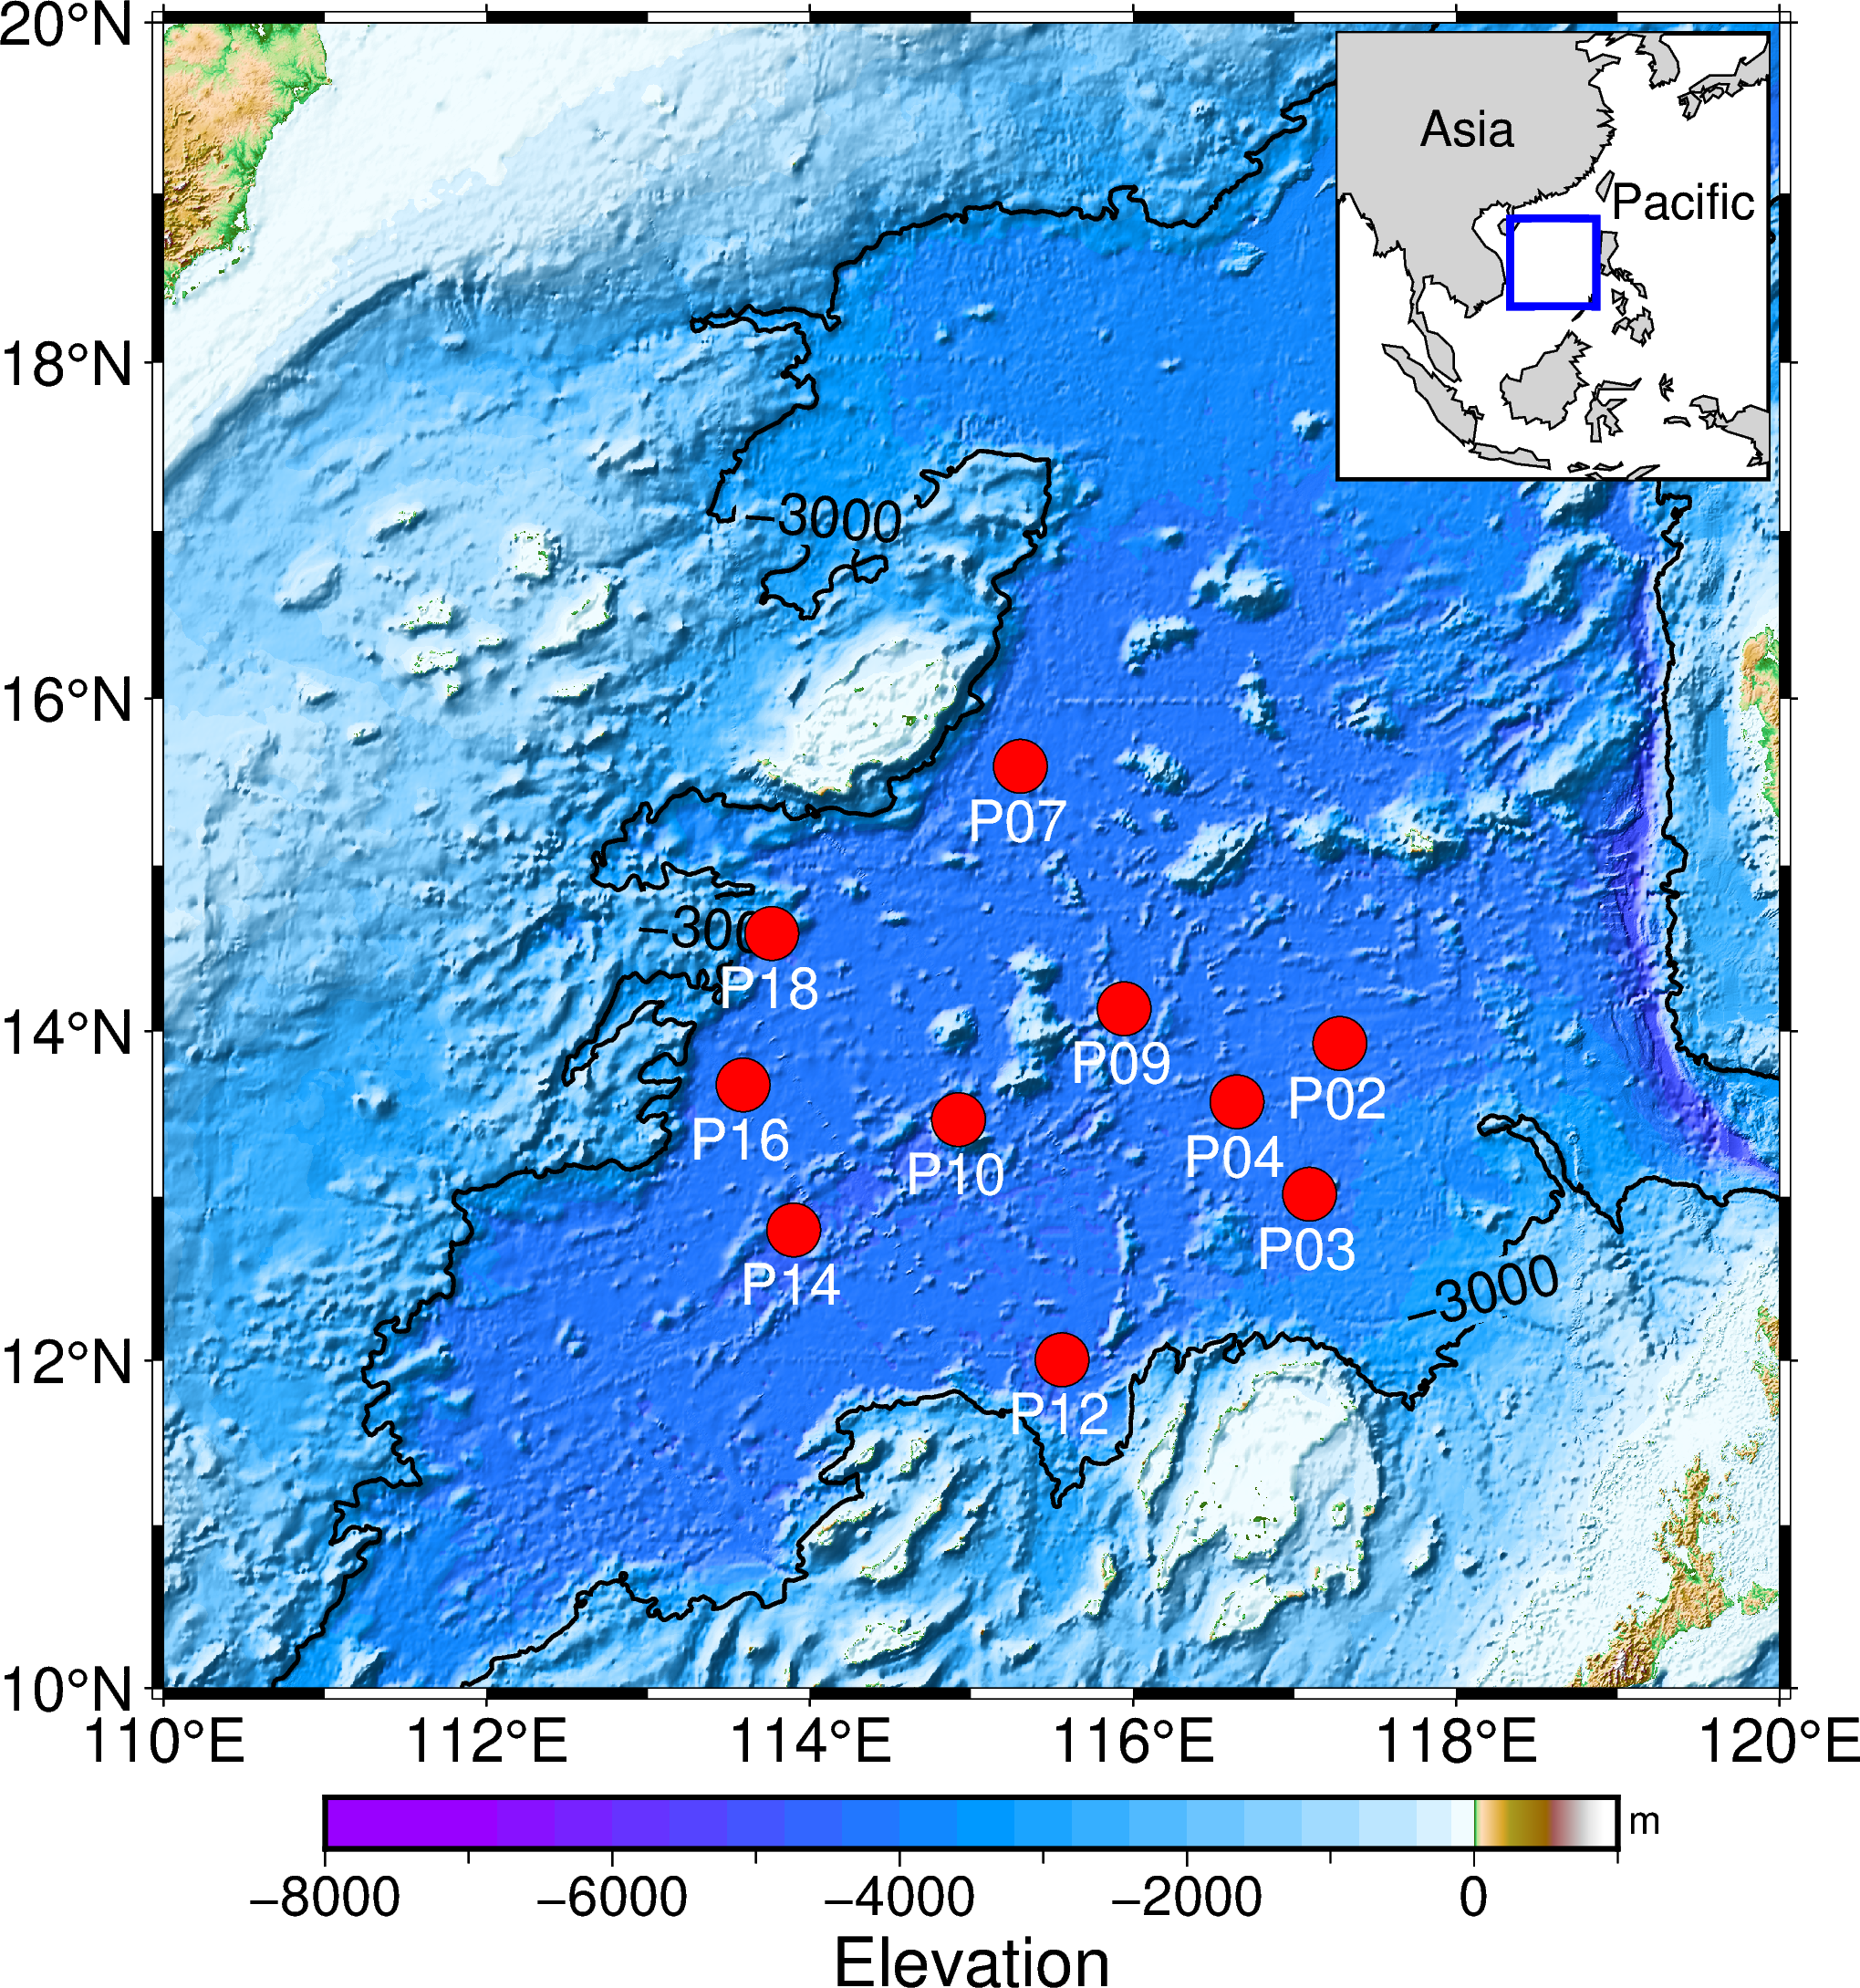

In [3]:
import pandas as pd
import pygmt

# 导入台站位置元数据文件
metadata_file = '3S_metadata.txt'

# 读取台站经纬度
metadata = pd.read_csv(metadata_file, sep='\t')

stations   = metadata['station']
latitudes  = metadata['latitude']
longitudes = metadata['longitude']

# 底图的范围
region = [110, 120, 10, 20]

# 加载地形起伏网格文件
grid = pygmt.datasets.load_earth_relief(resolution='15s', region=region)

# 制作CPT文件
pygmt.makecpt(cmap='globe', series=[-8000, 1000])

fig = pygmt.Figure()
pygmt.config(FONT_ANNOT_PRIMARY='16p')

# 绘制网格数据
fig.grdimage(grid=grid, shading='+d', projection='M15c', frame='a2f1')

# 绘制等高线
fig.grdcontour(grid=grid, annotation='1000+f15p', label_placement='d+20c', limit=[-3100, -2900], cut='1000', pen='1p')

ista = 0
for station in stations:
    
    latitude  = latitudes[ista]
    longitude = longitudes[ista]
    
    # 绘制台站
    fig.plot(x=longitude, y=latitude, style='c0.5c', fill='red', pen='black')
    
    # 添加文字
    fig.text(x=longitude, y=latitude, text=station, font='15p,white', justify='ML', offset='-0.5c/-0.5c')
    
    ista += 1

# 绘制插图
with fig.inset(
    position = 'jTR+o0.1c', # top right, x 和 y 方向的偏移量为 0.1 cm
    box = '+gwhite+p1p', # 填充白色
    region = [90, 140, -10, 40],
    projection = 'Cyl_stere/4c' # 圆柱立体投影，宽度为 15 cm
    ):
    
    fig.coast(
        area_thresh = 10000, # 最小面积（平方公里），小于该值的要素不显示
        land = 'lightgray',  # 陆地区域的填充色
        shorelines = '0.5p'  # 绘制海岸线
    )
    
    # 在插图中绘制一个矩形（'r'）以显示主图的区域
    # '+s'表示前两列为矩形左下角的经度和纬度，后两列为右上角的经度和纬度
    rectangle = [[region[0], region[2], region[1], region[3]]]
    fig.plot(data=rectangle, style='r+s', pen='2p,blue')
    
    # 添加文字
    fig.text(x=105, y=30, text='Asia', font='13p')
    fig.text(x=130, y=22, text='Pacific', font='13p')

with pygmt.config(FONT_LABEL='20p'):
    fig.colorbar(frame=['a2000f1000', 'x+lElevation', 'y+lm'])

fig.show()
fig.savefig('SCS_deployment.pdf')